In [1]:
from optimizers import *
from functions import *
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable

## A simple function

$$N = 3, K = 2, p \in \R^N, \forall_{0 \leq i < N} \, x^{[i]} \in \R^K, \, y^{[i]} \in \R$$

$$f : \R^K \times \R^N \to \R, \qquad f(x, p) = p_0^3 x_0 + p_1 x_1 + p_2 $$

In [2]:
xs = np.array([[1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7]])
ys = np.array([1, 2, 3, 4, 5, 6])


def f(x: np.ndarray, p: np.ndarray) -> np.ndarray:
    assert x.shape == (2,)
    assert p.shape == (3,)

    return p[0]**3 * x[0] + p[1] * x[1] + p[2]


def df(x: np.ndarray, p: np.ndarray) -> np.ndarray:
    assert x.shape == (2,)
    assert p.shape == (3,)

    return np.array([3 * p[0]**2 * x[0], x[1], 1])

def ddf(x: np.ndarray, p: np.ndarray) -> np.ndarray:
    assert x.shape == (2,)
    assert p.shape == (3,)

    return np.array([[6 * p[0] * x[0], 0, 0], [0, 0, 0], [0, 0, 0]])


def residue(
    f: Callable[[np.ndarray, np.ndarray], np.ndarray],
    xs: np.ndarray,
    ys: np.ndarray,
    p: np.ndarray,
) -> np.ndarray:
    assert xs.shape[1] == 2
    assert xs.shape[0] == ys.shape[0]
    assert p.shape == (3,)

    fs = np.array([f(x, p) for x in xs])

    return fs - ys


def residue_jacobian(
    df: Callable[[np.ndarray, np.ndarray], np.ndarray],
    ys: np.ndarray,
    xs: np.ndarray,
    p: np.ndarray,
) -> np.ndarray:
    assert xs.shape[1] == 2
    assert xs.shape[0] == ys.shape[0]
    assert p.shape == (3,)

    dfs = np.array([df(x, p) for x in xs])

    return np.array([dfs[i] for i in range(len(xs))])

def residue_hessian(
    ddf: Callable[[np.ndarray, np.ndarray], np.ndarray],
    ys: np.ndarray,
    xs: np.ndarray,
    p: np.ndarray,
) -> np.ndarray:
    assert xs.shape[1] == 2
    assert xs.shape[0] == ys.shape[0]
    assert p.shape == (3,)

    ddfs = np.array([ddf(x, p) for x in xs])

    return np.array([ddfs[i] for i in range(len(xs))])

In [3]:
def R_value(p: np.ndarray) -> np.ndarray:
    return residue(f, xs, ys, p)

def R_derivative(p: np.ndarray) -> np.ndarray:
    return residue_jacobian(df, ys, xs, p)

def R_hessian(p: np.ndarray) -> np.ndarray:
    return residue_hessian(ddf, ys, xs, p)

F = Function(R_value, R_derivative, R_hessian, N=3, M=6)

## Performence tests

Running Newton


Newton:   0%|          | 0/500 [00:00<?, ?it/s]

Newton: 100%|██████████| 500/500 [00:00<00:00, 4033.56it/s]


Running Gauss-Newton


Gauss-Newton: 100%|██████████| 500/500 [00:00<00:00, 8623.58it/s]


Running Gradient descent


Gradient descent: 100%|██████████| 500/500 [00:00<00:00, 12504.48it/s]


Running Levenberg-Marquardt (const)


Levenberg-Marquardt: 100%|██████████| 500/500 [00:00<00:00, 6174.85it/s]


Running Levenberg-Marquardt (modifying)


Levenberg-Marquardt: 100%|██████████| 500/500 [00:00<00:00, 1992.68it/s]


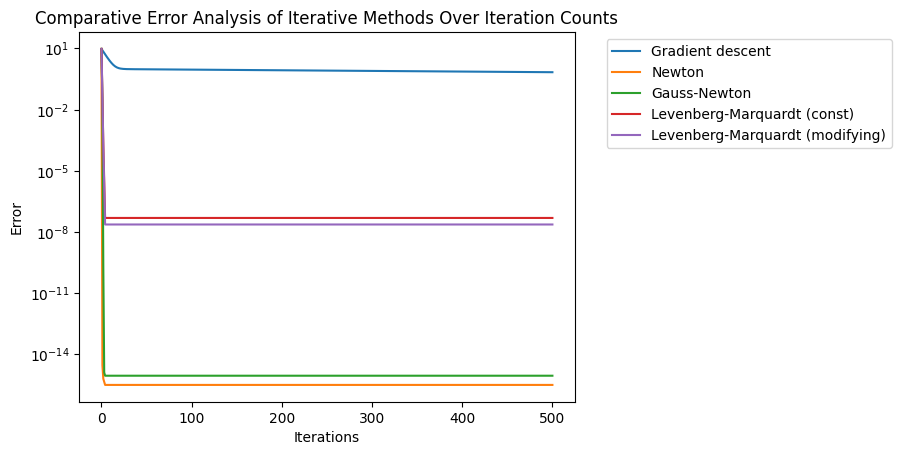

In [4]:
M = 3
max_iter = 500
p0 = np.random.randn(M)
alpha_gd = 1e-3
alpha_gn = 1.0
lambda0 = 1e-2
lambda_change = 1.1
step_max_iter = 10
step_tol = 1e-6

NEWTON = "Newton"
GAUSS_NEWTON = "Gauss-Newton"
GRADIENT_DESCENT = "Gradient descent"
LEVENBERG_MARQUARDT_CONST_PARAM = "Levenberg-Marquardt (const)"
LEVENBERG_MARQUARDT_MODIFYING_PARAM = "Levenberg-Marquardt (modifying)"
optimizer_names = [
    GRADIENT_DESCENT,
    NEWTON,
    GAUSS_NEWTON,
    LEVENBERG_MARQUARDT_CONST_PARAM,
    LEVENBERG_MARQUARDT_MODIFYING_PARAM,
]

errors = {name: [] for name in optimizer_names}
points = {name: [] for name in optimizer_names}

optimizer_functions = {
    NEWTON: lambda points, errs: newton(R=F, p0=p0, max_iter=max_iter, alpha=alpha_gn, points=points, errs=errs),
    GAUSS_NEWTON: lambda points, errs: gauss_newton(R=F, p0=p0, alpha=alpha_gn, max_iter=max_iter, points=points, errs=errs),
    GRADIENT_DESCENT: lambda points, errs: gradient_descent(R=F, p0=p0, alpha=alpha_gd, max_iter=max_iter, points=points, errs=errs),
    LEVENBERG_MARQUARDT_CONST_PARAM: lambda points, errs: (
        LevenbergMarquardt(R=F, lambda_param_fun=LevenbergMarquardt.LambdaParamConstant(lambda0=lambda0))
        .optimize(p0, max_iter, step_type="cgnr", step_max_iter=step_max_iter, step_tol=step_tol, points=points, errs=errs)
    ),
    LEVENBERG_MARQUARDT_MODIFYING_PARAM: lambda points, errs: (
        LevenbergMarquardt(R=F, lambda_param_fun=LevenbergMarquardt.LambdaParamDefaultModifier(lambda0=lambda0, lambda_change=lambda_change))
        .optimize(p0, max_iter, step_type="cgnr", step_max_iter=step_max_iter, step_tol=step_tol, points=points, errs=errs)
    ),
}

for name, optimizer in optimizer_functions.items():
    print("Running " + name)
    optimizer(points=points[name], errs=errors[name])

iters = np.arange(0, max_iter + 1)
for label, err in errors.items():
    try:
        plt.plot(iters, err, label=label)
    except:
        print("error in plotting for " + label)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("Iterations")
plt.ylabel("Error")
plt.yscale("log")
plt.title("Comparative Error Analysis of Iterative Methods Over Iteration Counts")
plt.show()